# O-mode Reflectometry simulator

Getting a simulated profile, extract the simulated signal from said profile and reconstruct the profile.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simps
from refo.sim_perf import sim_perf
import refo.functions as ref
from scipy import signal

## Simulating a typical AUG H-mode density profile

In [10]:
R0 = 2.22
Rant = 2.32
radius, dens = sim_perf(Rmid = 2.0, R0=R0, Rant=Rant)

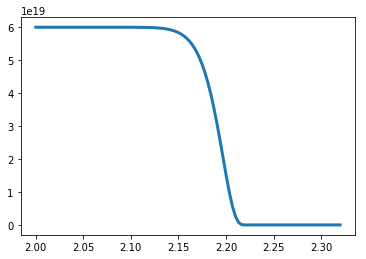

In [11]:
plt.plot(radius, dens, lw=3)
plt.show()

## Declaring a frequency sweep

In [158]:
fstart = 16e9
fstop = 50e9

In [13]:
dstart = ref.f2n(fstart)
dstop = ref.f2n(fstop)

In [14]:
perfmask = (dens >= dstart) & (dens <= dstop)

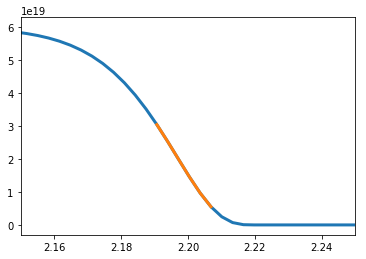

In [15]:
plt.plot(radius, dens, lw=3)
plt.plot(radius[perfmask], dens[perfmask], lw=3)
plt.xlim(2.15, 2.25)
plt.show()

In [16]:
fpts = 1024
fprobe = np.linspace(fstart, fstop, fpts, endpoint=True)

### Will this be possible without a for?

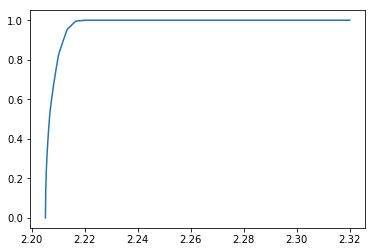

In [26]:
interpts = 1024
interp_perf = interp1d(radius, dens)
interp_rad = interp1d(dens, radius)
total_phase = []

fp = 25e9
dens_probe = ref.f2n(fp)

r_int = np.linspace(interp_rad(dens_probe), Rant, interpts, endpoint=True)
n_int = interp_perf(r_int)

#plt.plot(radius, dens, lw=3)
#plt.plot(r_int, n_int, lw=3)
#plt.xlim(2.15, 2.25)
NO = np.sqrt(1-n_int/dens_probe)
plt.plot(r_int, NO)
plt.show()

In [135]:
total_phase = []
#Avoid numerical errors due to the sqrt
epsi = 1e-9

#Do a numeric aproach 
for f in fprobe:
    dens_probe = ref.f2n(f)
    r_int = np.linspace(interp_rad(dens_probe)+epsi, Rant, interpts, endpoint=True)
    n_int = interp_perf(r_int)
    #Refractive index
    NO = np.sqrt(1-n_int/dens_probe)
        
    #Refractive index
    total_phase.append( 4.0*np.pi*f/3e8*simps(NO, x=r_int) )
    
    
#Not interested in the error, hence the [0]
total_phase = np.array(total_phase)

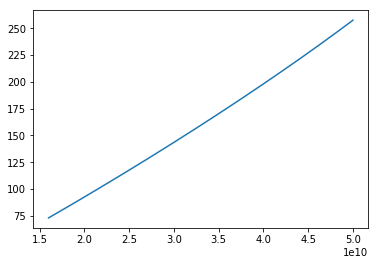

In [136]:
plt.plot(fprobe, total_phase)
plt.show()

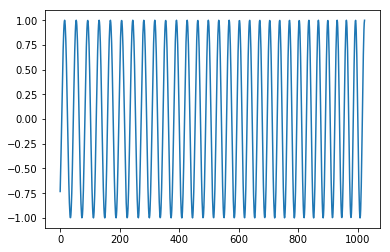

In [137]:
sig = np.cos(total_phase)
plt.plot(sig)
plt.show()

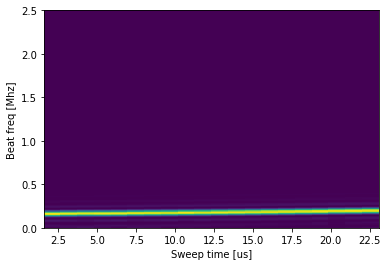

In [138]:
fsamp = 40e6
f, t, Sxx = signal.spectrogram(sig, fsamp*1e-6, nfft=1024, nperseg=128, noverlap=85)
f = f /(2.0*np.pi)
plt.pcolormesh(t, f, Sxx)
plt.ylim(0, 2.5)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

In [139]:
np.shape(Sxx)

(513, 21)

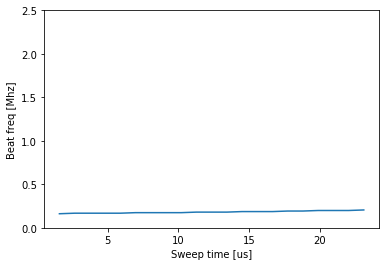

In [140]:
beat_f = f[np.argmax(Sxx, axis=0)]

plt.plot(t, beat_f)
plt.ylim(0, 2.5)
plt.xlabel('Sweep time [us]')
plt.ylabel('Beat freq [Mhz]')
plt.show()

In [141]:
Swp_rate = (fstop-fstart) / (1024.0/fsamp)
print Swp_rate

1.328125e+15


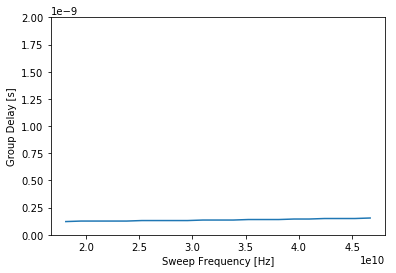

In [142]:
tau_g = beat_f*1e6 / Swp_rate
f_probsw = t*1e-6/(1024.0/fsamp)*(fstop-fstart) + fstart

plt.plot(f_probsw, tau_g)
plt.ylim(0, 2e-9)
plt.xlabel('Sweep Frequency [Hz]')
plt.ylabel('Group Delay [s]')
plt.show()

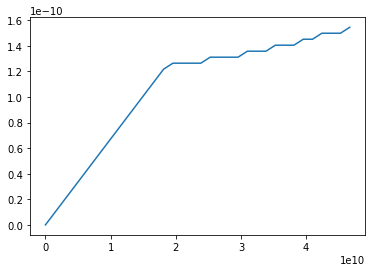

In [156]:
init_pts = 16
temp = np.linspace(0.0, f_probsw[0], init_pts)
f_init = np.concatenate((temp, f_probsw))
temp = np.linspace(0.0, tau_g[0], init_pts)
tau_init = np.concatenate((temp, tau_g))
plt.plot(f_init, tau_init)
plt.show()

In [157]:
dens_rec = ref.f2n(f_init)

37

In [154]:
pos_ref = []
Rassum = 2.25

#  FOR j = 1,np-1 DO $
#    FOR i = 1,j DO $
#      II[j] = II[j]+twoPI*itao[i]*(ASIN(fp[i]/fp[j])-ASIN(fp[i-1]/fp[j]))

ref_rad = np.zeros(len(tau_init))

for j in range(1, len(tau_init)):
    for i in range(1, j):
        ref_rad[j] = ref_rad[j] + 2.0*np.pi*tau_init[i]*(np.arcsin(f_init[i]/(f_init[j]) -
                                                         np.arcsin(f_init[i-1]/f_init[j])))

ref_rad = Rant - 3e8/(2.0*np.pi)*ref_rad

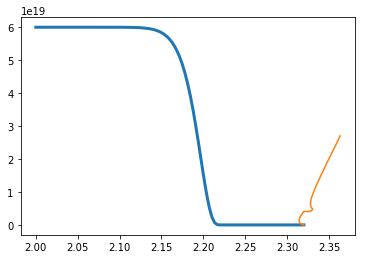

In [155]:
plt.plot(radius, dens, lw=3)
plt.plot(ref_rad, dens_rec)
plt.show()

array([ 0.10016742,  0.20135792])